# Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [3]:
random.seed(42) #ensuring to get the same random results in each run

### Dataset Setup

Here, the folder name is defined as `"animals"`, class labels are listed (`'dogs'`, `'cats'`, `'panda'`), each class is mapped to a numeric label, and the number of images to load per class is specified.


In [6]:
path = "animals"
classes = ['dogs', 'cats', 'panda']
classLabel = {'cats': 0, 'dogs': 1, 'panda': 2}
imgEachClass = {'cats': 34, 'dogs': 33, 'panda': 33}

# Dataset & Prepocessing

> In this portion, 100 images in total are randomly selected for each class. Each image is then converted into grayscale and resized to 32×32. The processed data is stored along with their numeric and textual labels in the `data` list. This preprocessing helps reduce the image dimensions and lowers computation time. Additionally, the data is shuffled tensurece randomness for model training and evaluatioll?


In [9]:
data = []

for cls in classes:
    folder = os.path.join(path, cls)
    imgs = os.listdir(folder)
    selection = random.sample(imgs, imgEachClass[cls])  # selecting total 100 images randomly

    for img_name in selection:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray_scale, (32, 32))

        data.append((resize, classLabel[cls], cls))

print(f"Total Number of Images: {len(data)}")
random.shuffle(data)


Total Number of Images: 100


### Data Visualization

This part visualizes the first 100 preprocessed images in a 10×10 grid with their class names as titles.

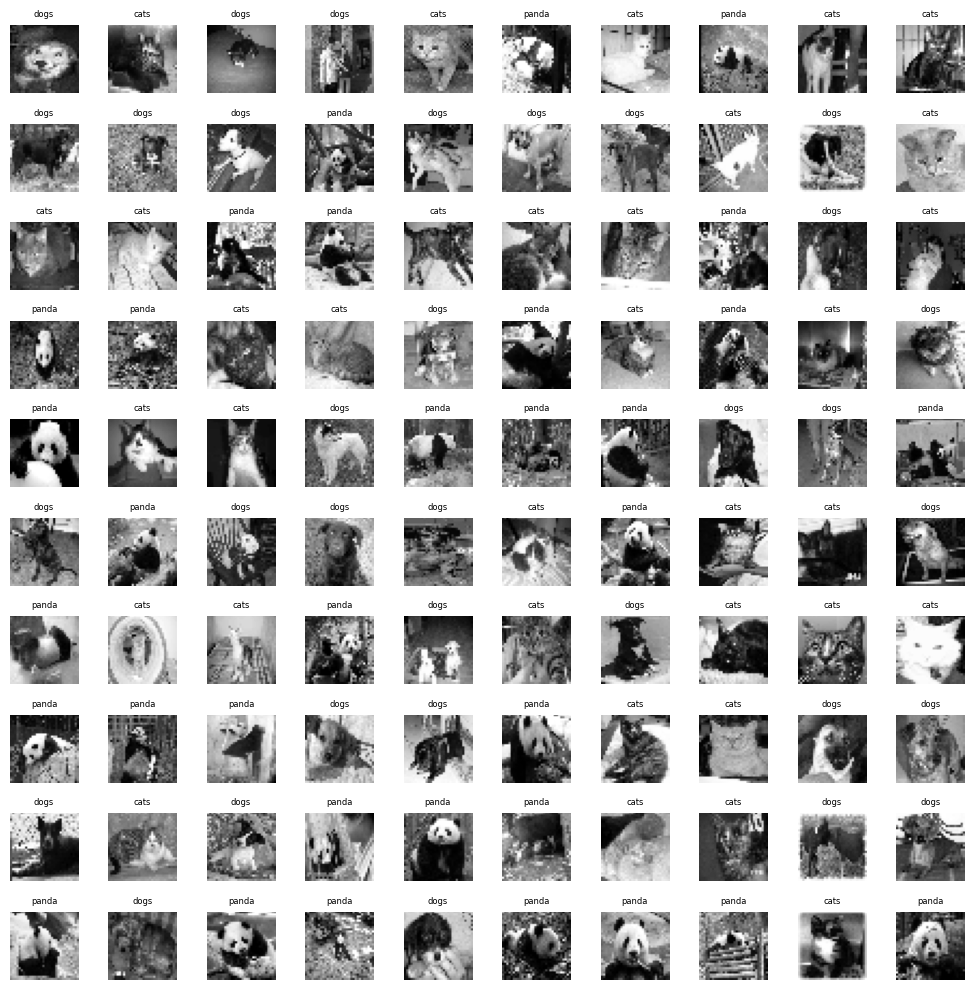

In [12]:
plt.figure(figsize=(10, 10))
for i in range(100):
    img, label, name = data[i]
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(name, fontsize=6)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Evaluation  & Building

### Distance Matrices
The functions are implemented for Manhattan and Euclidean, two types of distance metrics used to compute the distance between each test image and the training set.

In [15]:
#L1
def manhattan(a,b):
    return np.sum(np.abs(a-b))

#L2
def euclidean(a,b):
    return np.sqrt(np.sum((a-b)**2))

### 5-fold

The dataset is split into 5 equal folds to peroform 5-fold cross-validation.

In [18]:
fold_size = len(data) // 5 #20 images in each fold
folds = [data[i*fold_size : (i+1)*fold_size] for i in range(5)]

### KNN

Here, the dataset is trained using the KNN algorithm with 5-fold cross-validation through the following steps:

1. For each fold, one part is selected as the validation set while the remaining four parts are combined to form the training set.
2. Features and labels are separated for both training and validation data.
3. For each fold, the value of K ranges from 1 to 40.
4. For each K, the distance between each validation image and all training images is computed using either the Manhattan or Euclidean distance function.
5. The distances for a particular validation image with respect to the training images are sorted in ascending order.
6. The majority vote is taken from the top K nearest neighbors to determine the predicted class label.
7. The accuracy for each K in the current fold is stored in the accuracies list.
8. The accuracies for all 5 folds are stored in the fold_accuracies list.
9. Finally, the knn function is called separately for both the Manhattan and Euclidean distance metrics.
10. 'tqdm' is used to display a progress bar during the validation process, making it easier to track the computation progress for each fold and each value of K.

In [21]:
def knn(folds, distance_func, K, use_tqdm=True):
    fold_accuracies = []

    #validation and train data seperation
    for i in range(5):
        val_fold = folds[i]
        train_folds = folds[:i] + folds[i+1:]
        train_data = []
        for f in train_folds:
            train_data.extend(f)

        #feature and label seperation
        val_x = [x[0] for x in val_fold]
        val_y = [x[1] for x in val_fold]
        train_x = [x[0] for x in train_data]
        train_y = [x[1] for x in train_data]

        accuracies = []

        #k = 1-40
        for k in K:
            correct = 0

            #validation fold
            itr = range(len(val_x))
            if use_tqdm:
                itr = tqdm(itr, desc=f"K = {k}, {i+1}-Fold")

            #image in the validation fold
            for j in itr:
                distances = []

                for m in range(len(train_x)):
                    d = distance_func(val_x[j], train_x[m])
                    distances.append((d, train_y[m]))

                distances.sort(key=lambda x: x[0]) #ascending
                top_k = distances[:k]

                # max voting
                label_count = {}
                for d, label in top_k:
                    if label not in label_count:
                        label_count[label] = 1
                    else:
                        label_count[label] += 1

                pred_label = max(label_count, key=label_count.get)

                if pred_label == val_y[j]:
                    correct += 1

            acc = (correct / len(val_x)) * 100
            accuracies.append(acc)

        fold_accuracies.append(accuracies)
        average_accuracies = np.mean(fold_accuracies, axis=0)

    return fold_accuracies, average_accuracies
K = np.arange(1, 41)

# Results and Analysis

The fold-wise and average accuracies for each K are stored for both L1 and L2 and the function 'plot_knn_accuracy' is called which plots average KNN accuracies for Manhattan (L1) and Euclidean (L2) distances across different K values in different graphs.

In [61]:
fold_acc_L1, average_acc_L1 = knn(folds, manhattan, K)
fold_acc_L2, average_acc_L2 = knn(folds, euclidean, K)

def plot_knn_accuracy(K, fold_accuracies, average_accuracies, title, color):
    plt.figure(figsize=(10, 6))

    # Plot fold accuracies
    for i, fold_accuracy in enumerate(fold_accuracies):
        plt.plot(K, fold_accuracy, 'o-', label=f'{i+1}-Fold', alpha=0.7)

    # Plot average accuracy
    plt.plot(K, average_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=4)

    plt.xlabel('K')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(np.arange(0, 41, 1))
    plt.tight_layout()
    plt.show()

K = 40, 5-Fold: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 455.42it/s]


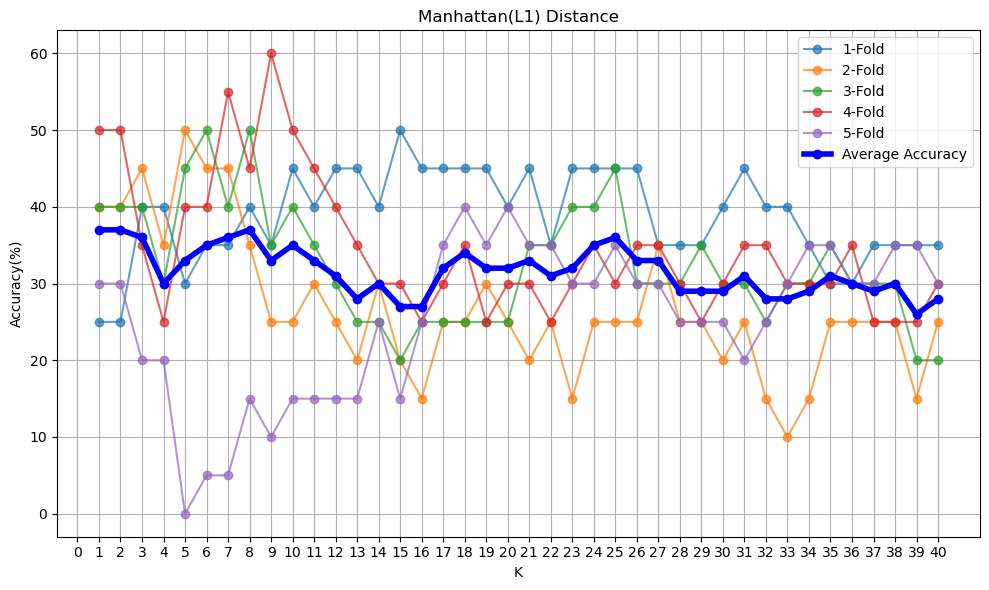

In [62]:
plot_knn_accuracy(K, fold_acc_L1, average_acc_L1, title='Manhattan(L1) Distance', color='blue')

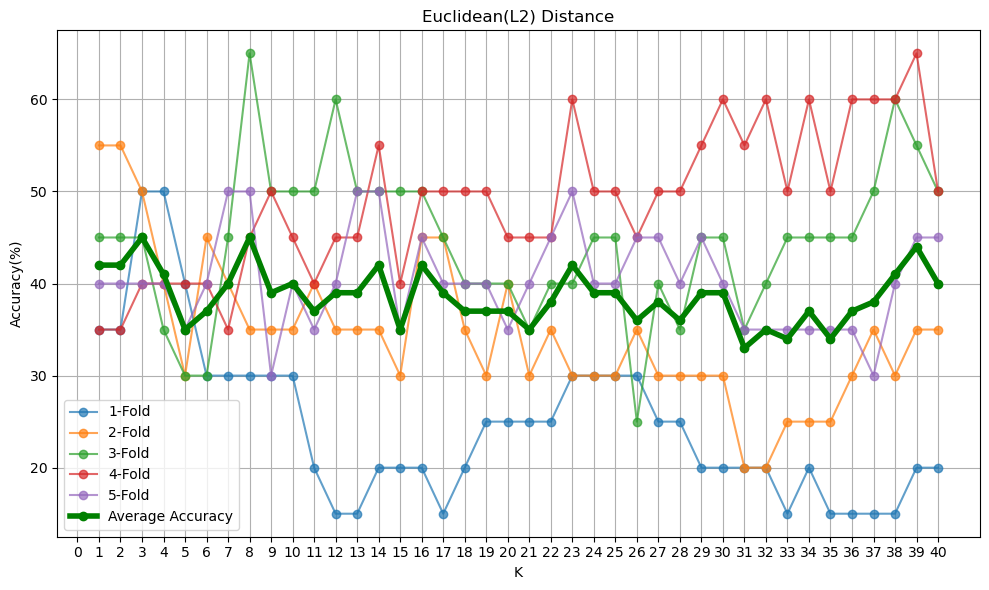

In [63]:
plot_knn_accuracy(K, fold_acc_L2, average_acc_L2, title='Euclidean(L2) Distance', color='green')

# Discussion
The accuracy results for Manhattan (L1) and Euclidean (L2) distances varied with k. L1 started around 37% and decreased to 28% by k=40, while L2 began at 42% and dropped below 40%. Both distance measures showed fluctuations across the range of 
k, indicating sensitivity to k values.

The dataset consists of grayscale images resized to 32×32 pixels, using pixel values as features. Given the moderate similarity between the classes (cats, dogs, and pandas) and the low complexity of the images, L2 captures overall similarity, performed slightly better. L1 is more robust to small variations but does not capture the smooth gradients in these images as well as L2.

A limitation of this approach is the relatively low accuracy, likely due to the simplicity of using raw pixel features. To improve performance, future work could explore more advanced models, such as Convolutional Neural Networks (CNNs), which are better suited for image data. Additionally, experimenting with other classification techniques or applying data augmentation could further enhance model accuracy.

# Top 5 Predictions
This portion displays the top 5 predictions made by the model on a set of test images through following steps:

1.  First, The dataset is split into 80% training and 20% testing data.
2.  Then, the images, numeric labels, and names are separated for both training and test sets.
3.  A function 'predict_knn' is defined that
   i) Calculates distances between each test image and all training images using the specified distance metric (using the function for Manhattan or Euclidean).
   ii) Sorts distances and selects the top K nearest neighbors.
   iii) Uses majority voting to determine the predicted label for each test image.
4. The first 5 images from the test set are selected for visualization.
5. redictions for the selected 5 test images are computed using both Euclidean and Manhattan distance metrics with K=5.
6. The 'classLabel' dictionary is reversed to map numeric labels back to class names for display.
7. A matplotlib figure is created showing the 5 test images along with The true class label, Predicted labels using L2 (Euclidean), Predicted labels using L1 (Manhattan)

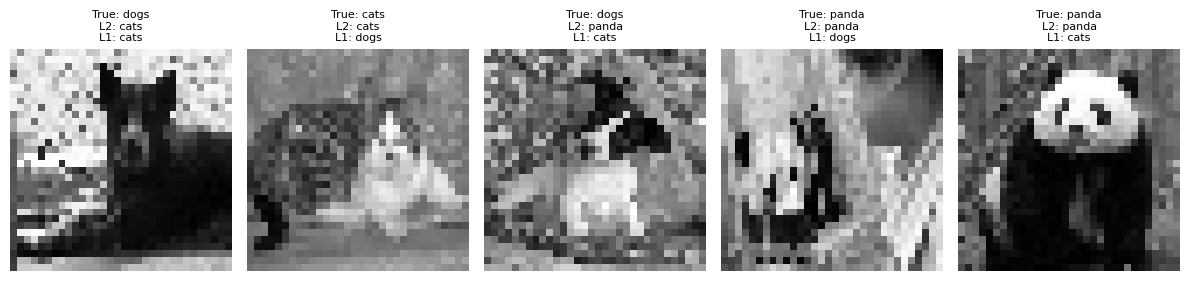

In [27]:
#random.shuffle(data)
split_idx = int(0.8 * len(data)) # 80-20 train-test split
train_data = data[:split_idx]
test_data = data[split_idx:]

train_x = [x[0] for x in train_data]
train_y = [x[1] for x in train_data]
test_x = [x[0] for x in test_data]
test_y = [x[1] for x in test_data]
test_names = [x[2] for x in test_data]

def predict_knn(X_train, y_train, X_test, k, dist_func):
    predictions = []
    for test_img in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = dist_func(test_img, X_train[i])
            distances.append((dist, y_train[i]))
        distances.sort(key=lambda x: x[0])
        top_k = distances[:k]

        # Majority vote
        label_count = {}
        for d, label in top_k:
            label_count[label] = label_count.get(label, 0) + 1
        pred_label = max(label_count, key=label_count.get)
        predictions.append(pred_label)
    return predictions

# selecting top 5 test samples
k = 5
top5_test_imgs = test_x[:5]
top5_true_labels = test_y[:5]
top5_names = test_names[:5]

# Predictions using both distances
top5_preds_euclidean = predict_knn(train_x, train_y, top5_test_imgs, k, euclidean)
top5_preds_manhattan = predict_knn(train_x, train_y, top5_test_imgs, k, manhattan)

class_names = {v: k for k, v in classLabel.items()}

# displaying images and predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(top5_test_imgs[i], cmap='gray')
    plt.title(f"True: {class_names[top5_true_labels[i]]}\nL2: {class_names[top5_preds_euclidean[i]]}\nL1: {class_names[top5_preds_manhattan[i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()